<a href="https://colab.research.google.com/github/Bingle-labake/deeplearn/blob/master/3/1/3_1_37_cifar10_cnn_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145653 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.14-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
cd /content/drive/colab/3_1_37/

/content/drive/colab/3_1_37


##卷积神经网络
在此 notebook 中，我们将训练一个 **CNN** 对 CIFAR-10 数据库中的图像进行分类。

该数据库中的图像是很小的彩色图像，分成 10 个类别，下面是一些图像示例。

![替代文字](http://p9.qhimg.com/t01fef6b5af7cec1bcd.png)


###测试 [CUDA](https://pytorch.org/docs/stable/cuda.html)

由于它们是较大的 (32x32x3) 图像，所以有必要使用 GPU 加快训练速度。CUDA 是一个并行计算平台，CUDA 张量和普通张量一样，只是它们利用 GPU 进行计算。

In [0]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...




---
##加载[数据](https://pytorch.org/docs/stable/torchvision/datasets.html)¶

下载过程可能需要几分钟。我们加载训练和测试数据，将训练数据拆分为训练集和验证集，然后为每个数据集创建数据加载器。


In [0]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


###可视化一批训练数据

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

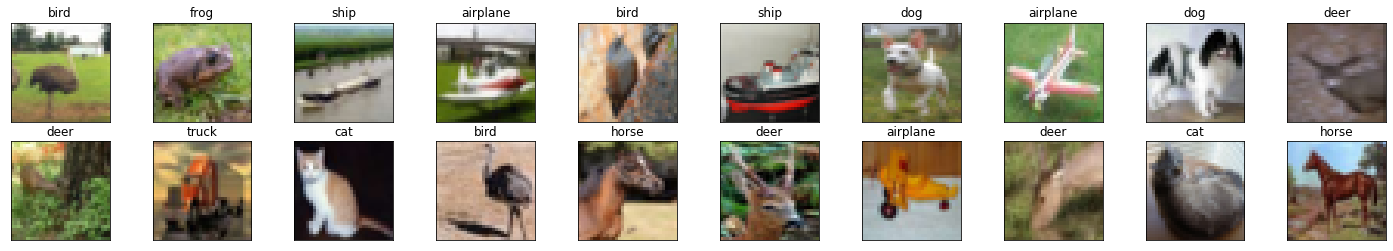

In [0]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

###详细查看图像

我们将标准化的红绿蓝 (RGB) 颜色通道当做三个独立的灰度图像。

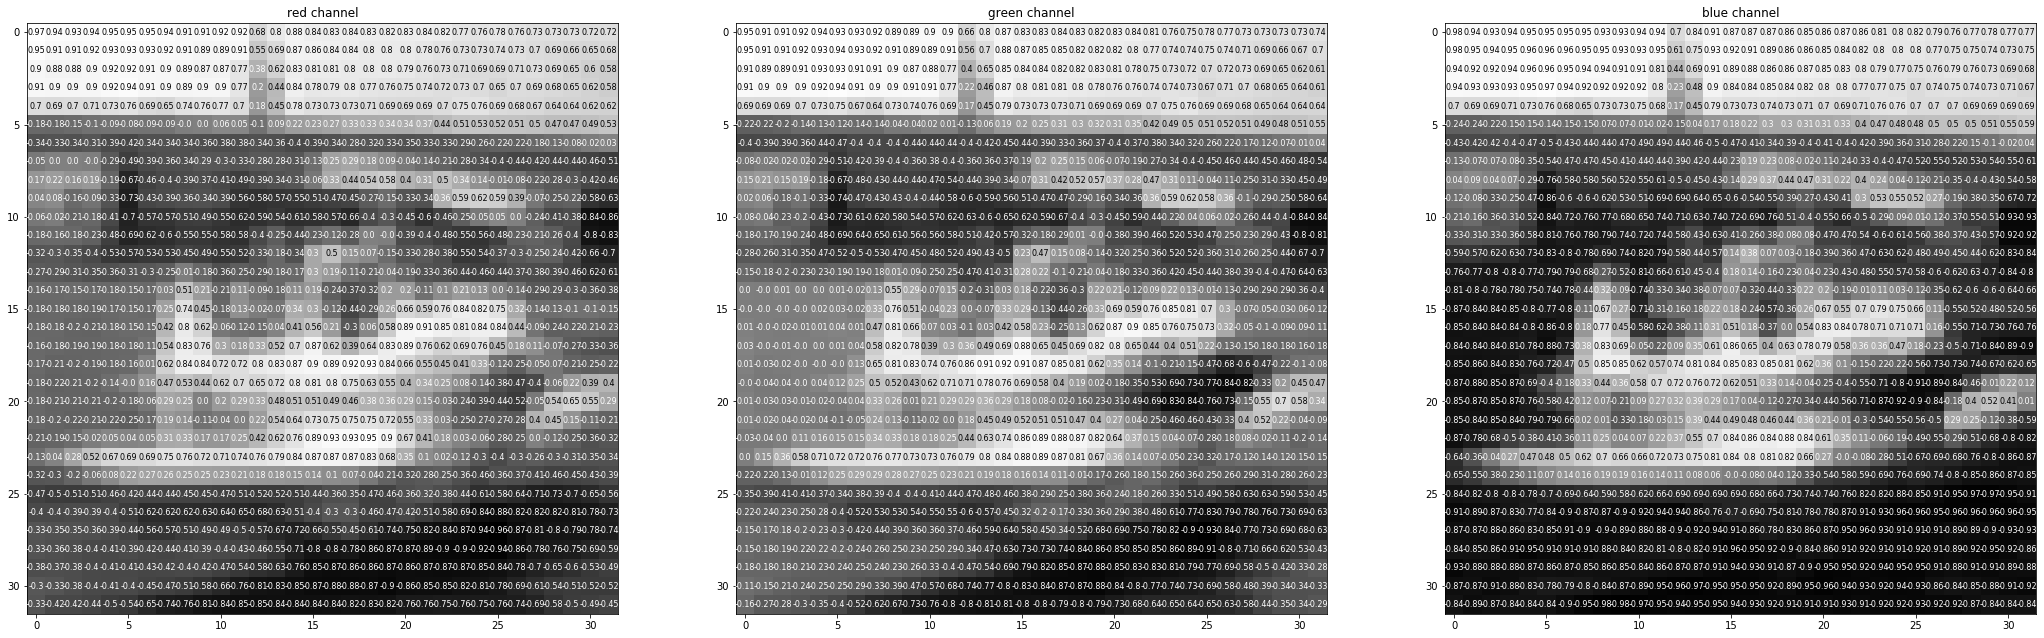

In [0]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

##定义网络[架构](https://pytorch.org/docs/stable/nn.html)

你将定义 CNN 架构。MLP 使用线性全连接层，而你将使用以下层级：


*   卷积层，可以看做过滤图像的堆叠。
*   最大池化层，缩减输入的 x-y 尺寸，仅保留上个层级最活跃的像素。
*   普通的线性层级和丢弃层，避免过拟合并生成 10 维输出。

下图显示的是具有 2 个卷积层的网络，在代码中，我们提供了包含一个卷积层和一个池化层的起始代码。


**TODO：定义一个具有多个卷积层的模型，并定义前馈网络行为。**

添加的卷积层越多，模型能检检测的颜色和形状规律越复杂。建议最终模型包含 2 或 3 个卷积层，并在中间添加线性和丢弃层，避免过拟合。

在定义你自己的模型时，建议查看现有的研究成果和相关模型的实现代码。你可以参阅此 PyTorch 分类示例或这个更复杂的 Keras 示例，帮助你判断最终选择什么结构。

**卷积层的输出大小**

要计算给定卷积层的输出大小，我们可以执行以下运算（摘自斯坦福的 [cs231n 课程](http://cs231n.github.io/convolutional-networks/#layers)）：


> 我们可以使用函数计算输出的空间大小，该函数接受输入大小 (W)、核/过滤器大小 (F)、应用的步长 (S)，以及边界使用的零填充量 (P)。计算 output_W 有多少个神经元的正确公式为 (W−F+2P)/S+1。


例如，如果输入为 7x7，过滤器为 3x3，步长为 1，填充为 0，那么输出为 5x5。如果步长为 2，那么输出为 3x3。

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
   
        self.fc1 = nn.Linear(64*4*4, 500)
        self.fc2 = nn.Linear(500, 10)
        
        self.dropout = nn.Dropout(0.25)


    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 64*4*4)
        
        x = self.dropout(x)        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


###指定[损失函数](https://pytorch.org/docs/stable/nn.html#loss-functions)和[优化器](https://pytorch.org/docs/stable/optim.html)

选择最适合此分类任务的损失和优化函数。上述代码示例可以作为很好的起点；即[这个 PyTorch 分类示例example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py)或[这个更复杂的 Keras 示例](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py)。请特别注意学习速率的值，因为此值决定了模型如何收敛到一个很小的错误。

**TODO：定义损失和优化器，看看它们对损失的变化有何影响。**

In [0]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.008, momentum=0.9)

###训练网络

注意观察训练和验证损失如何逐渐降低；如果验证损失开始增大，表明可能过拟合了。

In [0]:
# number of epochs to train the model
n_epochs = 30 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.300208 	Validation Loss: 0.250471
Validation loss decreased (inf --> 0.250471).  Saving model ...
Epoch: 2 	Training Loss: 0.953478 	Validation Loss: 0.216401
Validation loss decreased (0.250471 --> 0.216401).  Saving model ...
Epoch: 3 	Training Loss: 0.825990 	Validation Loss: 0.186156
Validation loss decreased (0.216401 --> 0.186156).  Saving model ...
Epoch: 4 	Training Loss: 0.745841 	Validation Loss: 0.183508
Validation loss decreased (0.186156 --> 0.183508).  Saving model ...
Epoch: 5 	Training Loss: 0.696657 	Validation Loss: 0.183457
Validation loss decreased (0.183508 --> 0.183457).  Saving model ...
Epoch: 6 	Training Loss: 0.648940 	Validation Loss: 0.174115
Validation loss decreased (0.183457 --> 0.174115).  Saving model ...
Epoch: 7 	Training Loss: 0.615542 	Validation Loss: 0.170217
Validation loss decreased (0.174115 --> 0.170217).  Saving model ...
Epoch: 8 	Training Loss: 0.591089 	Validation Loss: 0.177518
Epoch: 9 	Training Loss: 0.568015 

####加载验证损失最低的模型

In [0]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

####验证训练的网络

用全新数据（模型之前未见过的数据）测试训练过的模型！在这些测试图像上的准确率达到 70% 左右就算不错的结果了（你还可以获得更高的准确率，加油！）

In [0]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.844113

Test Accuracy of airplane: 73% (733/1000)
Test Accuracy of automobile: 79% (798/1000)
Test Accuracy of  bird: 60% (608/1000)
Test Accuracy of   cat: 56% (566/1000)
Test Accuracy of  deer: 67% (678/1000)
Test Accuracy of   dog: 52% (525/1000)
Test Accuracy of  frog: 77% (771/1000)
Test Accuracy of horse: 80% (806/1000)
Test Accuracy of  ship: 75% (759/1000)
Test Accuracy of truck: 81% (818/1000)

Test Accuracy (Overall): 70% (7062/10000)


#####思考：模型的薄弱之处是什么，如何改进？

答案：部分分类的效果不理想，如鸟、猫或狗，这一类的动物可能是偏小；可以增加更多的样本进行训练，又或者对参数进行调优，通过训练网络的评估得知，epochs过多导致效果变差；又或者减少或增大变化速率lr参数。

####可视化示例测试结果

TypeError: ignored

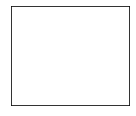

In [0]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
  images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))